In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [55]:
import kid_readout.analysis.archive
reload(kid_readout.analysis.archive)

<module 'kid_readout.analysis.archive' from '/home/gjones/kid_readout/kid_readout/analysis/archive.py'>

In [8]:
bare = kid_readout.analysis.archive.build_simple_archive('/data/readout/pkl/2015-06-1[578]*.pkl')

In [6]:
import glob

In [9]:
tin = kid_readout.analysis.archive.build_simple_archive('/data/readout/pkl/2015-09-1*.pkl')

In [10]:
bare.shape,tin.shape

((2240, 91), (1632, 91))

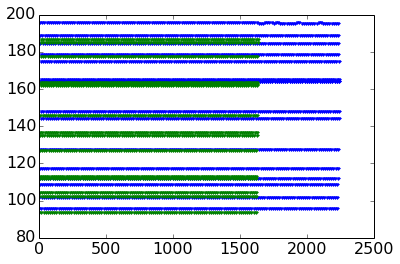

In [12]:
plot(bare.f_0,'.')
plot(tin.f_0,'.')

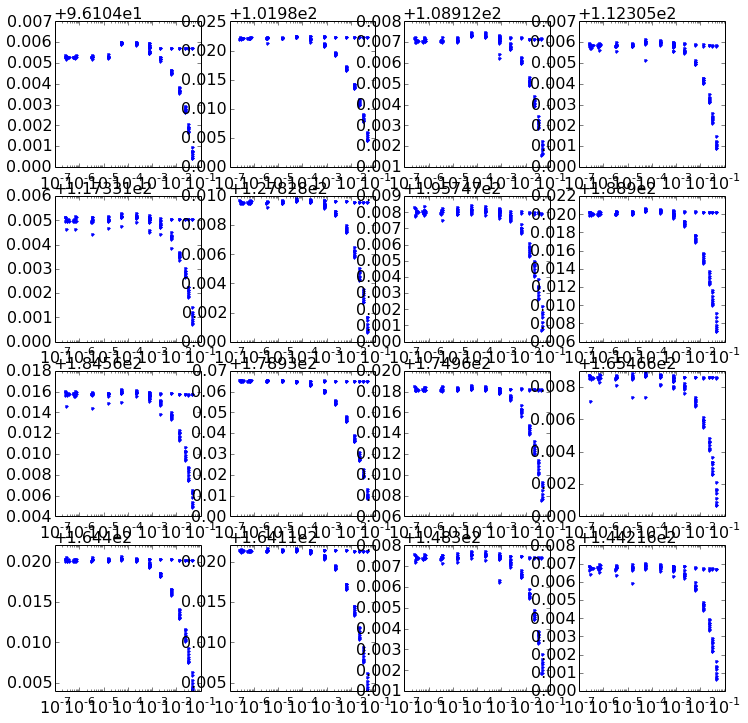

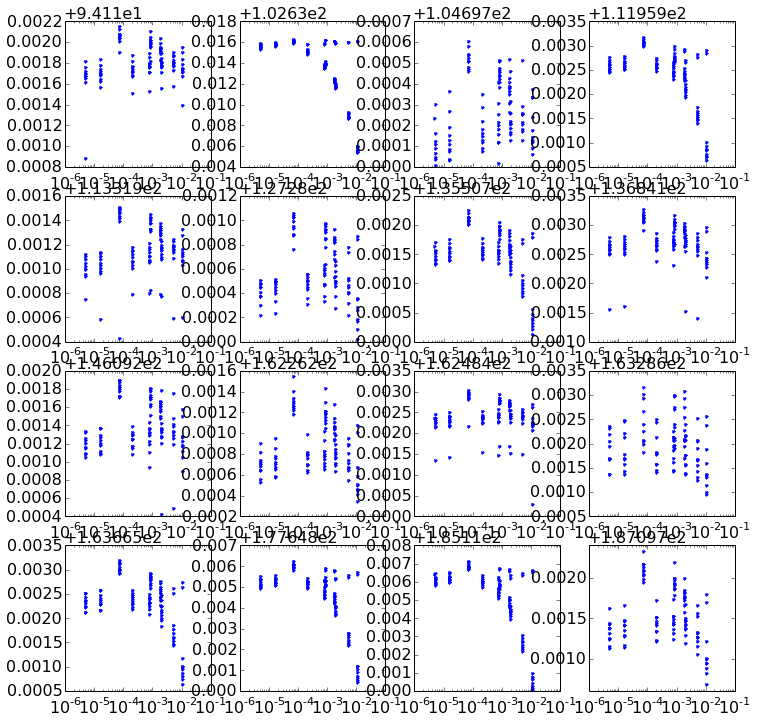

In [13]:
for df in [bare,tin]:
    fig,axs = plt.subplots(4,4,figsize=(12,12))
    for k in range(16):
        ax = axs.flatten()[k]
        res = df[df.resonator_index==k]
        ax.semilogx(res.zbd_voltage,res.f_0,'.')

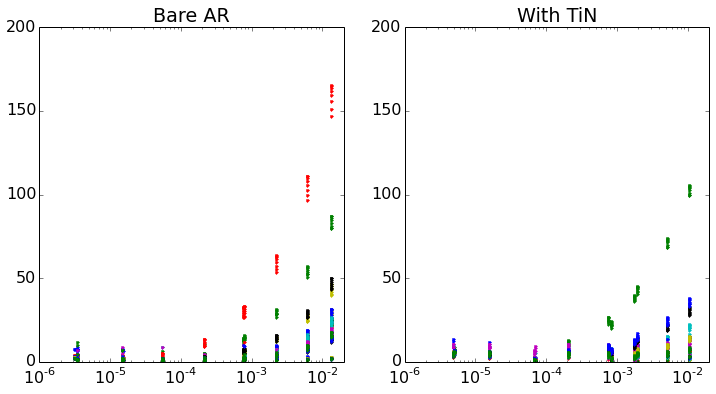

In [25]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
titles = ['Bare AR','With TiN']
for df,ax,title in zip([bare,tin],axs,titles):
    for k in range(16):
#        ax = axs#.flatten()[k]
        res = df[df.resonator_index==k]
        x = 1-res.f_0/res.f_0.max()
        ax.semilogx(res.zbd_voltage,x*1e6,'.')
    ax.set_ylim(0,200)
    ax.set_xlim(1e-6,2e-2)
    ax.set_title(title)

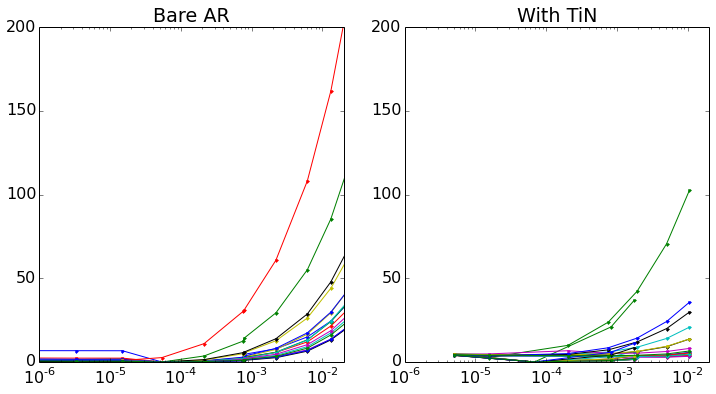

In [80]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
titles = ['Bare AR','With TiN']
bare41 = bare[(bare.atten==41) & (bare.timestream_modulation_duty_cycle==0)]
tin41 = tin[(tin.atten==41) & (tin.timestream_modulation_duty_cycle==0)]
for df,ax,title in zip([bare41,tin41],axs,titles):
    for k in range(16):
#        ax = axs#.flatten()[k]
        res = df[df.resonator_index==k]
        x = 1-res.f_0/res.f_0.max()
        ax.semilogx(res.zbd_voltage,x*1e6,'.-')
    ax.set_ylim(0,200)
    ax.set_xlim(1e-6,2e-2)
    ax.set_title(title)

0.000770334
0.00612691


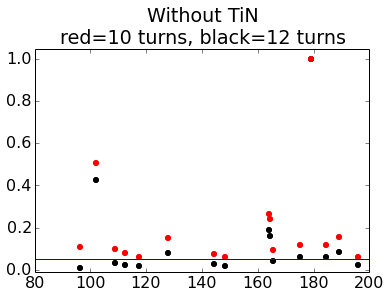

In [106]:
for turns,color in zip([12,10],['k','r']):
    bare_on = bare41[bare41.mmw_atten_total_turns==turns]
    print bare_on.zbd_voltage.mean()
    bare_off = bare[(bare.timestream_modulation_duty_cycle==1.0) & (bare.atten==41)]
    illuminated_index = 9
    illuminated_on = bare_on[bare_on.resonator_index==illuminated_index].f_0.mean()
    illuminated_off = bare_off[bare_off.resonator_index==illuminated_index].f_0.mean()
    illuminated_x = -(illuminated_on-illuminated_off)/illuminated_off
    for k in range(16):
        off = bare_off[bare_off.resonator_index==k].f_0.mean()
        on = bare_on[bare_on.resonator_index==k].f_0
        x=(off-on.mean())/off
        plot(off,x/illuminated_x,'o',color=color,mew=0)
gca().set_title('Without TiN\nred=10 turns, black=12 turns')
ylim(-0.01,1.05)
gca().axhline(0.05)
savefig('/home/gjones/paper_plots/2015-09-24-without-TiN.pdf',bbox_inches='tight')

0.000791553
0.0050483


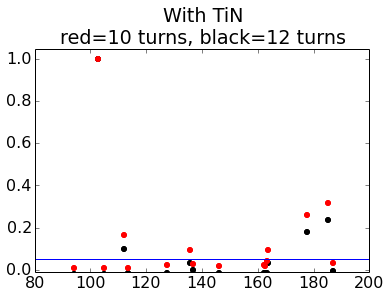

In [107]:
for turns,color in zip([12,10],['k','r']):
    bare_on = tin41[tin41.mmw_atten_total_turns==turns]
    print bare_on.zbd_voltage.mean()
    bare_off = tin[(tin.timestream_modulation_duty_cycle==1.0) & (tin.atten==41)]
    illuminated_index = 1
    illuminated_on = bare_on[bare_on.resonator_index==illuminated_index].f_0.mean()
    illuminated_off = bare_off[bare_off.resonator_index==illuminated_index].f_0.mean()
    illuminated_x = -(illuminated_on-illuminated_off)/illuminated_off
    for k in range(16):
        off = bare_off[bare_off.resonator_index==k].f_0.mean()
        on = bare_on[bare_on.resonator_index==k].f_0
        x=(off-on.mean())/off
        plot(off,x/illuminated_x,'o',color=color,mew=0)
gca().set_title('With TiN\nred=10 turns, black=12 turns')
gca().axhline(0.05)
ylim(-0.01,1.05)
savefig('/home/gjones/paper_plots/2015-09-24-with-TiN.pdf',bbox_inches='tight')

In [44]:
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil
import kid_readout.analysis.dataframe

In [56]:
bare = kid_readout.analysis.archive.add_total_mmw_attenuator_turns(bare)
tin = kid_readout.analysis.archive.add_total_mmw_attenuator_turns(tin)

In [35]:
for k,row in bare.iterrows():
    #print row
    break


In [36]:
row.Q

64217.13502953063

In [37]:
def model_from_row(row):
    res,bif,prefer_bif = kid_readout.analysis.resonator.fit_resonator(row.sweep_freqs_MHz,row.sweep_s21,errors=row.sweep_errors,delay_estimate=row.delay)
    return res

In [65]:
bare.mmw_atten_total_turns.value_counts()

12    320
18    160
17    160
16    160
15    160
14    160
13    160
11    160
10    160
9     160
8     160
7     160
6     160
dtype: int64

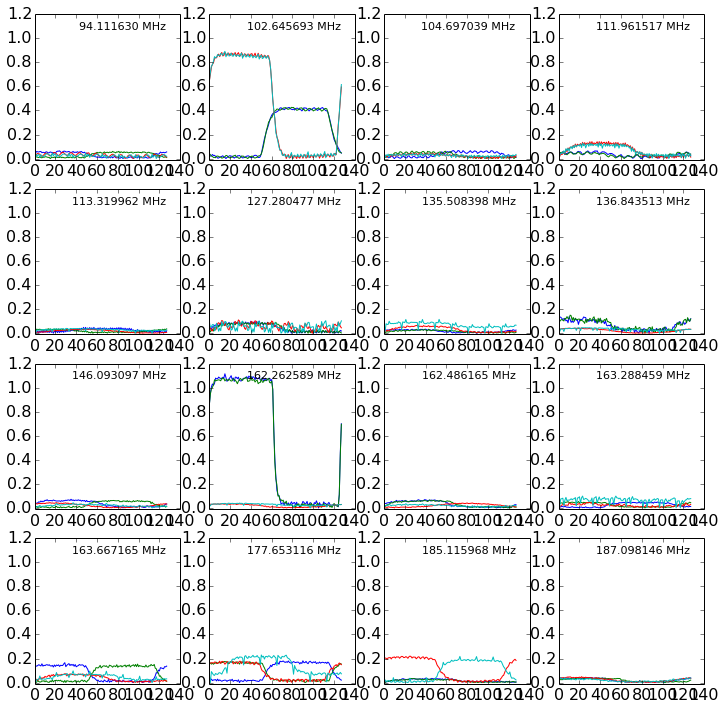

In [114]:
fig,axs = plt.subplots(4,4,figsize=(12,12))
for df in [bare,tin]:
    nturns = 15
    modulated = df[(df.timestream_modulation_duty_cycle==0.5) & (df.mmw_atten_total_turns==nturns)]
    for k,row in modulated.iterrows():
        ax = axs.flatten()[row.resonator_index]
        res = model_from_row(row)
        x = 1e6*kid_readout.analysis.resonator.normalized_s21_to_detuning(row.folded_normalized_timeseries,res)
        #print x
        ax.plot(x.real-x.real.min())
        #ax.plot(x.imag)
for k in range(16):
    ax = axs.flatten()[k]
    ax.set_ylim(-.01,1.2)
    f0 = modulated[modulated.resonator_index==k].f_0.iloc[0]
    ax.text(0.9,0.95,('%f MHz' % f0),transform=ax.transAxes,ha='right',va='top',size='x-small')

In [58]:
modulated.mmw_atten_total_turns.value_counts()

12    64
18    32
17    32
16    32
15    32
14    32
13    32
11    32
10    32
9     32
8     32
7     32
6     32
dtype: int64